### Bounding Box 바깥 부분 masking


In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 경로 설정

# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/'
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/'

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/out_box_masking/image/'
out_json_path = '/workspace/Data_Augumentation/out_box_masking/label/'


#### 이미지 증강 후 저장

In [3]:
# Train Sadness

img_dir = img_path + 'train/sadness/'
output_dir = out_img_path + 'train/sadness/' 

csv_path = json_path + 'train/' + 'train_sadness_1.csv'
output_csv_path = out_json_path + 'train/' + 'mask_boxout_train_sadness.csv'

df = pd.read_csv(csv_path)

In [ ]:
# 변경된 이미지 정보 저장 리스트 초기화
processed_data = []

# 이미지 처리
for index, row in df.iterrows():
    try:
        # 파일 이름과 바운딩 박스 좌표 읽기
        img_file = row['filename']
        x_coords = [row['annot_A.boxes.minX'], row['annot_B.boxes.minX'], row['annot_C.boxes.minX'], row['avg_box.minX']]
        y_coords = [row['annot_A.boxes.minY'], row['annot_B.boxes.minY'], row['annot_C.boxes.minY'], row['avg_box.minY']]
        x_max_coords = [row['annot_A.boxes.maxX'], row['annot_B.boxes.maxX'], row['annot_C.boxes.maxX'], row['avg_box.maxX']]
        y_max_coords = [row['annot_A.boxes.maxY'], row['annot_B.boxes.maxY'], row['annot_C.boxes.maxY'], row['avg_box.maxY']]

        # 최종 바운딩 박스 계산
        minX, minY = int(min(x_coords)), int(min(y_coords))
        maxX, maxY = int(max(x_max_coords)), int(max(y_max_coords))

        # 이미지 경로 설정
        img_path = os.path.join(img_dir, img_file)
        output_path = os.path.join(output_dir, f"mask_boxout_{img_file}")

        # 이미지 읽기
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load image: {img_path}")
            continue

        # 마스킹 처리
        mask = np.zeros_like(img, dtype=np.uint8)
        mask[minY:maxY, minX:maxX] = img[minY:maxY, minX:maxX]

        # 리사이즈
        mask = cv2.resize(mask, (640, 640))

        # 바운딩 박스 좌표 수정
        minX = int(minX * (640 / img.shape[1]))
        minY = int(minY * (640 / img.shape[0]))
        maxX = int(maxX * (640 / img.shape[1]))
        maxY = int(maxY * (640 / img.shape[0]))

        # 처리된 이미지 저장
        os.makedirs(output_dir, exist_ok=True)
        cv2.imwrite(output_path, mask)
        print(f"Processed and saved: {output_path}")

        # 변경된 데이터 저장
        processed_data.append({
            'filename': f"mask_boxout_{img_file}",
            'maxX': maxX,
            'maxY': maxY,
            'minX': minX,
            'minY': minY,
            'faceExp_uploader': row['faceExp_uploader'],
        })
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# 처리된 데이터 저장
if processed_data:
    processed_df = pd.DataFrame(processed_data)
    os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
    processed_df.to_csv(output_csv_path, index=False)
    print(f"Processed CSV saved to: {output_csv_path}")
else:
    print("No data processed.")


#### 증강된 데이터 확인
- 데이터 수 비교(image, label) : 원본 vs 증강
- 증강된 이미지 & Bounding Box 시각화

In [5]:
# 폴더 내 이미지 파일 개수 세기
def count_images_in_folder(folder_path):
    IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}
    image_count = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if os.path.splitext(file)[1].lower() in IMAGE_EXTENSIONS:
                image_count += 1
    return image_count


# 이미지와 바운딩 박스 시각화 함수 (증강 데이터)
def visualize_images_with_boxes(image_paths, boxes):
    """
    여러 이미지를 한 줄에 5개씩 출력하며 바운딩 박스를 시각화합니다.

    Args:
        image_paths (list): 이미지 파일 경로 리스트
        boxes (list): 바운딩 박스 좌표 정보 리스트 (각각 dict 형태)
    """
    # 행렬로 표시할 이미지 개수
    num_images = len(image_paths)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols  # 행 개수 계산

    # 서브플롯 설정
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    axes = axes.ravel()  # 2D 배열을 1D 배열로 변환

    # 각 이미지를 서브플롯에 표시
    for i in range(len(axes)):
        if i < num_images:
            # 이미지 읽기
            img = cv2.imread(image_paths[i])
            if img is None:
                axes[i].axis('off')
                axes[i].set_title("Image not found")
                continue

            # BGR -> RGB 변환
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 바운딩 박스 그리기
            cv2.rectangle(
                img,
                (boxes[i]['minX'], boxes[i]['minY']),
                (boxes[i]['maxX'], boxes[i]['maxY']),
                color=(255, 0, 0),
                thickness=2,
            )

            # 이미지 출력
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Image {i+1}")
        else:
            # 남은 빈 서브플롯 숨기기
            axes[i].axis('off')

    # 전체 플롯 조정
    plt.tight_layout()
    plt.show()


# 이미지,박스 시각화 함수 정의 (원본 데이터)
def visualize_boxes(dataframe, image_dir):
    """
    CSV 데이터를 기반으로 이미지와 바운딩 박스를 시각화합니다.

    Args:
        dataframe (pd.DataFrame): 바운딩 박스 정보가 담긴 데이터프레임
        image_dir (str): 이미지 파일이 저장된 디렉토리
    """
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2행 x 5열 서브플롯
    axes = axes.ravel()

    # 최대 10개의 데이터만 시각화
    for idx, (_, row) in enumerate(dataframe.head(10).iterrows()):
        filename = row['filename']
        image_path = os.path.join(image_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image {filename} not found in directory {image_dir}.")
            axes[idx].axis('off')
            continue

        # 이미지 읽기 및 변환
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[idx].imshow(image)
        axes[idx].axis('off')

        # 바운딩 박스 그리기
        for annot_key in ['annot_A', 'annot_B', 'annot_C']:
            box_prefix = f"{annot_key}.boxes"
            if f"{box_prefix}.minX" in row and f"{box_prefix}.minY" in row:
                x_min = int(row[f"{box_prefix}.minX"])
                y_min = int(row[f"{box_prefix}.minY"])
                x_max = int(row[f"{box_prefix}.maxX"])
                y_max = int(row[f"{box_prefix}.maxY"])
                
                # 바운딩 박스 플롯
                x = [x_min, x_max, x_max, x_min, x_min]
                y = [y_min, y_min, y_max, y_max, y_min]
                axes[idx].plot(x, y, label=annot_key)

        axes[idx].set_title(filename[:10], fontsize=8)
        axes[idx].legend(fontsize=6)

    # 빈 서브플롯 숨기기
    for i in range(len(dataframe.head(10)), 10):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [6]:
# 원본 경로
img_path = '/workspace/#Ub370#Uc774#Ud130/Data/img/'
json_path = '/workspace/#Ub370#Uc774#Ud130/Data/label/'

# 출력 경로
out_img_path = '/workspace/Data_Augumentation/out_box_masking/image/'
out_json_path = '/workspace/Data_Augumentation/out_box_masking/label/'

img_dir = img_path + 'train/sadness/'
output_dir = out_img_path + 'train/sadness/' 

csv_path = json_path + 'train/' + 'train_sadness_1.csv'
output_csv_path = out_json_path + 'train/' + 'mask_boxout_train_sadness.csv'

In [12]:
image_count = count_images_in_folder(img_dir)
image_count_mask = count_images_in_folder(output_dir)

print(f"폴더 내 이미지 파일 개수: {image_count}")
print(f"증강 폴더 내 이미지 파일 개수: {image_count_mask}")


폴더 내 이미지 파일 개수: 1499
증강 폴더 내 이미지 파일 개수: 1499


In [8]:
df = pd.read_csv(csv_path)
df_mask = pd.read_csv(output_csv_path)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   filename            1499 non-null   object 
 1   faceExp_uploader    1499 non-null   object 
 2   annot_A.boxes.maxX  1499 non-null   float64
 3   annot_A.boxes.maxY  1499 non-null   float64
 4   annot_A.boxes.minX  1499 non-null   float64
 5   annot_A.boxes.minY  1499 non-null   float64
 6   annot_B.boxes.maxX  1499 non-null   float64
 7   annot_B.boxes.maxY  1499 non-null   float64
 8   annot_B.boxes.minX  1499 non-null   float64
 9   annot_B.boxes.minY  1499 non-null   float64
 10  annot_C.boxes.maxX  1499 non-null   float64
 11  annot_C.boxes.maxY  1499 non-null   float64
 12  annot_C.boxes.minX  1499 non-null   float64
 13  annot_C.boxes.minY  1499 non-null   float64
 14  avg_box.maxX        1499 non-null   float64
 15  avg_box.maxY        1499 non-null   float64
 16  avg_bo

In [10]:
df_mask.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1499 entries, 0 to 1498
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          1499 non-null   object
 1   maxX              1499 non-null   int64 
 2   maxY              1499 non-null   int64 
 3   minX              1499 non-null   int64 
 4   minY              1499 non-null   int64 
 5   faceExp_uploader  1499 non-null   object
dtypes: int64(4), object(2)
memory usage: 70.4+ KB


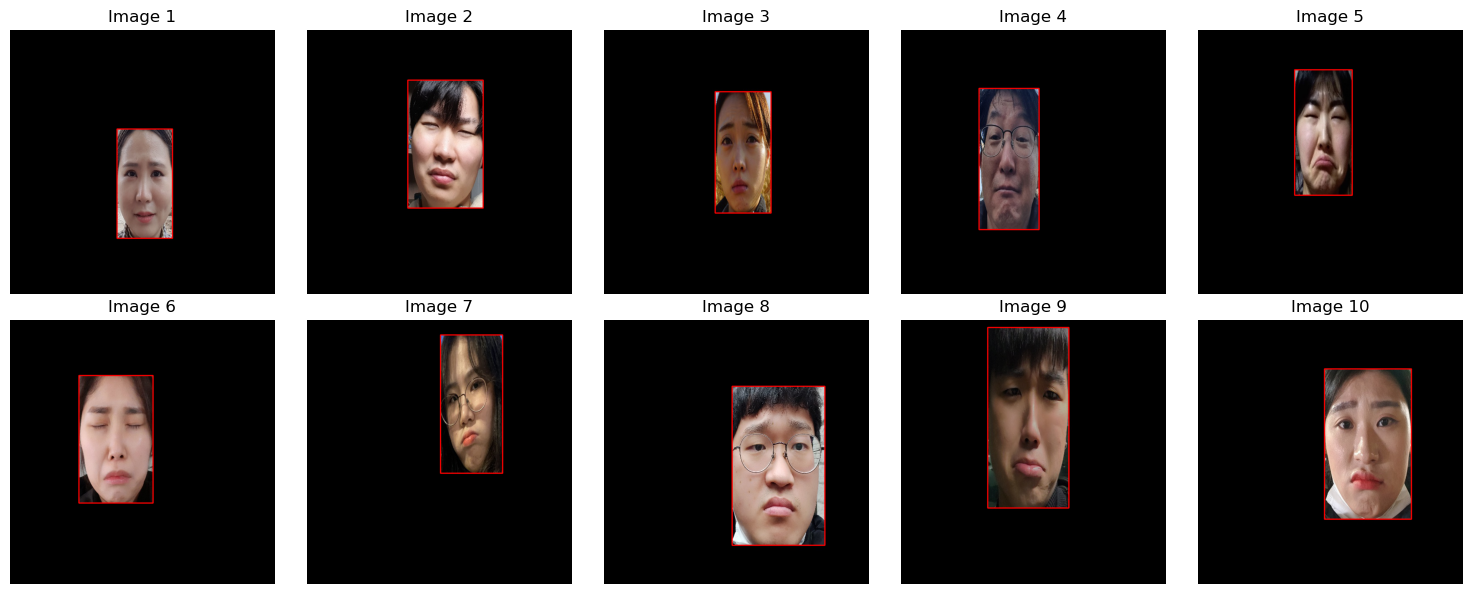

In [11]:
# 이미지와 바운딩 박스 시각화 (증강 데이터)
image_paths = []
boxes = []

for _, row in df_mask.head(10).iterrows():
    img_file = row['filename']
    image_path = os.path.join(output_dir, img_file)
    image_paths.append(image_path)

    box_info = {
        'minX': int(row['minX']),
        'minY': int(row['minY']),
        'maxX': int(row['maxX']),
        'maxY': int(row['maxY']),
    }
    boxes.append(box_info)

# 시각화
visualize_images_with_boxes(image_paths, boxes)

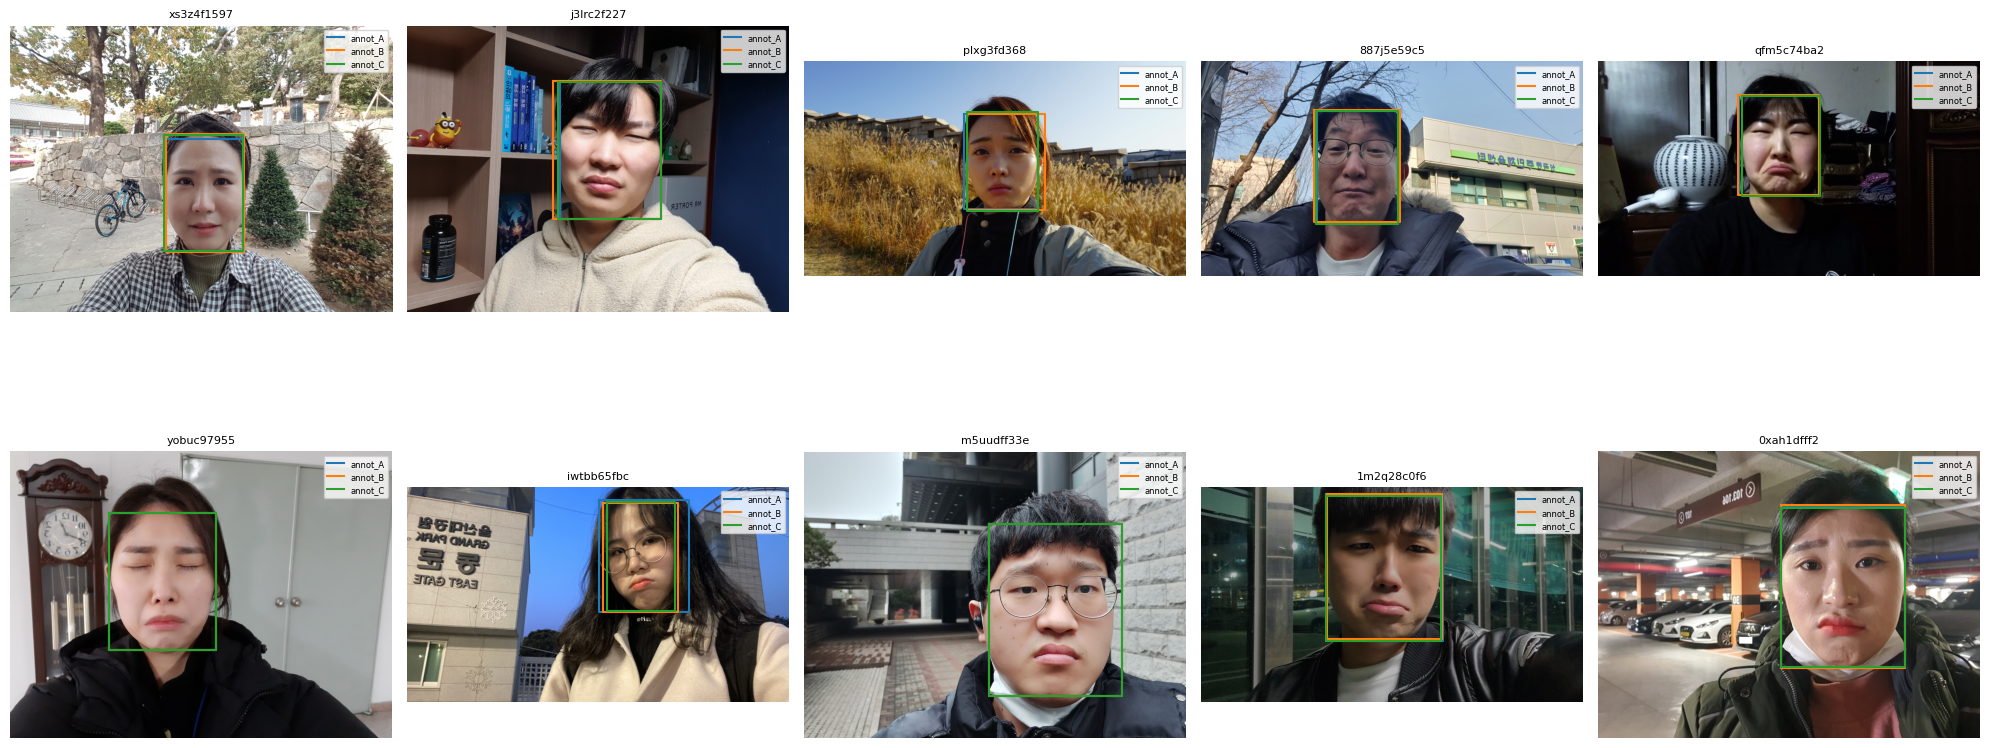

In [19]:
# 이미지와 바운딩 박스 시각화 (원본 데이터)

visualize_boxes(df, img_dir)